In [1]:
import pickle
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import FastICA
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import nibabel as nib
import ants
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
import cv2
import bigbadbrain as bbb
import scipy
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm
import matplotlib.colors as mcolors
import matplotlib
import tqdm
import brainsss

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


# Creat L vs R voxel plots for all SVs

In [2]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"

In [3]:
### Load Supercluster Signals ###
file = os.path.join(cluster_dir, "20221202_SC_signals.npy")
supercluster_signals = np.load(file)
supercluster_signals.shape

(501, 30456)

In [4]:
file = os.path.join(cluster_dir,"20221122_behavior_fwd.npy")
beh_fwd = np.load(file)
print(beh_fwd.shape)

file = os.path.join(cluster_dir,"20221122_behavior_turn.npy")
beh_turn = np.load(file)
print(beh_turn.shape)

(30456,)
(30456,)


In [5]:
file = os.path.join(cluster_dir, 'superclusters_more.npy')
superclusters = np.load(file)
#with 249 there will be clusters 1-250 inclusive (len=250). cluster 140 is background
superclusters_250 = superclusters[:,:,:,249]
# right brain gets +250 to cluster ID so now 500 clusters
superclusters_250[157:,:,:] += 250

In [6]:
def make_circle_aperture(num_bins,radius):

    xs = np.arange(0,num_bins)
    ys = np.arange(0,num_bins)

    aperture = []
    for x in xs:
        for y in ys:
            if (x-num_bins/2)**2+(y-num_bins/2)**2<radius**2:
                aperture.append(1.)
            else:
                aperture.append(0.)
    aperture = np.asarray(aperture)
    aperture = np.reshape(aperture,(num_bins,num_bins))
    return aperture

Text(0.5, 0.72, 'Clusters 21, 271')

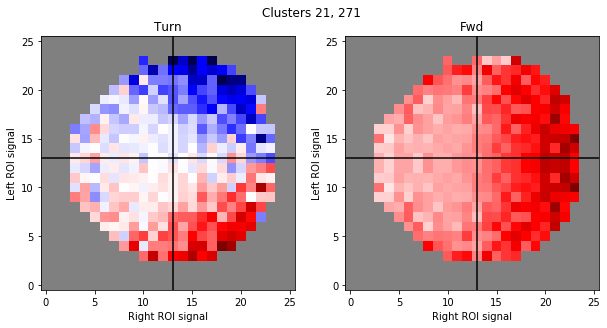

In [7]:
plt.figure(figsize=(10,10))

cluster_ = 21#185#77#147#47#21

x_data = supercluster_signals[cluster_,:]
y_data = supercluster_signals[cluster_+250,:]

r = np.deg2rad(45)
rot = [[np.cos(r),-np.sin(r)],[np.sin(r),np.cos(r)]]
m = np.vstack((x_data,y_data)).T
out = np.matmul(m,rot)
x_data = out[:,1]; y_data = out[:,0]

# model = PCA()
# pca = model.fit_transform(np.vstack((x_data,y_data)).T)
# x_data = pca[:, 1]
# y_data = pca[:, 0]

# x_data = x_data*np.std(y_data)/np.std(x_data) #make spherical

x_data /= np.std(x_data)/0.15
y_data /= np.std(y_data)/0.15 # normalize

behavior = beh_turn

for k,(behavior,title) in enumerate(zip([beh_turn, beh_fwd],['Turn','Fwd'])):
    plt.subplot(1,2,k+1)
    start=-.6
    stop=.6
    num_bins=40
    min_num_samples=10

    # Define bins
    bins = np.linspace(start,stop,num_bins)

    # Assign neural values to bin numbers
    idx_x, idx_y = np.digitize(x_data,bins), np.digitize(y_data,bins)

    binned_signal = []
    sample_count = []
    for i in range(num_bins):
        mask_x = (idx_x == i)
        for j in range(num_bins):
            mask_y = (idx_y == j)
            mask = mask_x & mask_y

            binned_signal.append(np.mean(behavior[mask]))
            sample_count.append(np.count_nonzero(~np.isnan(behavior[mask])))

    binned_signal = np.reshape(binned_signal,(num_bins, num_bins))
    sample_count = np.reshape(sample_count,(num_bins, num_bins))

    #smooth
    #binned_signal = scipy.ndimage.gaussian_filter(binned_signal,sigma=1,truncate=1)
    #binned_signal = scipy.ndimage.uniform_filter(binned_signal, size=2, mode='constant')

    # Symeterize
    if title == 'Turn':
        binned_signal = (binned_signal+binned_signal[::-1]*-1)/2
    elif title == 'Fwd':
        binned_signal = (binned_signal+binned_signal[::-1])/2
    
    # Hide bins containing too few data points
    sample_count = (sample_count+sample_count[::-1])/2
    binned_signal[np.where(sample_count<=min_num_samples)] = np.nan

    #mask a circle
    radius = 11
    #binned_signal *= make_circle_aperture(num_bins,radius)
    aperture = make_circle_aperture(num_bins,radius)
    aperture[aperture==0]=np.nan
    binned_signal*=aperture
    
    #normalize
    binned_signal /= np.max(np.nan_to_num(binned_signal))
    
    #crop
    binned_signal = binned_signal[7:-7,7:-7]
    
    cmap = plt.cm.get_cmap("seismic")
    cmap.set_bad(color='grey')
    plt.imshow(binned_signal,vmin=-1,vmax=1,cmap=cmap,origin='lower')
    plt.ylabel('Left ROI signal')
    plt.xlabel('Right ROI signal')
    #plt.plot([0,num_bins],[0,num_bins],color='k')
    #plt.colorbar()
    #plt.ylim(7,num_bins-8)
    #plt.xlim(7,num_bins-8)
    plt.title(title)
    plt.axhline(13,color='k')
    plt.axvline(13,color='k')
plt.suptitle(F"Clusters {cluster_}, {cluster_+250}",y=.72)

In [7]:
all_turn_hists = []
all_fwd_hists = []
all_turn_max = []
all_fwd_max = []

for cluster_ in tqdm.tqdm(range(251)):

    x_data = supercluster_signals[cluster_,:]
    y_data = supercluster_signals[cluster_+250,:]

    r = np.deg2rad(45)
    rot = [[np.cos(r),-np.sin(r)],[np.sin(r),np.cos(r)]]
    m = np.vstack((x_data,y_data)).T
    out = np.matmul(m,rot)
    x_data = out[:,1]; y_data = out[:,0]

    # model = PCA()
    # pca = model.fit_transform(np.vstack((x_data,y_data)).T)
    # x_data = pca[:, 1]
    # y_data = pca[:, 0]

    # x_data = x_data*np.std(y_data)/np.std(x_data) #make spherical

    x_data /= np.std(x_data)/0.15
    y_data /= np.std(y_data)/0.15 # normalize

    for k,(behavior,title) in enumerate(zip([beh_turn, beh_fwd],['Turn','Fwd'])):
        start=-.6
        stop=.6
        num_bins=40
        min_num_samples=10

        # Define bins
        bins = np.linspace(start,stop,num_bins)

        # Assign neural values to bin numbers
        idx_x, idx_y = np.digitize(x_data,bins), np.digitize(y_data,bins)

        binned_signal = []
        sample_count = []
        for i in range(num_bins):
            mask_x = (idx_x == i)
            for j in range(num_bins):
                mask_y = (idx_y == j)
                mask = mask_x & mask_y

                binned_signal.append(np.mean(behavior[mask]))
                sample_count.append(np.count_nonzero(~np.isnan(behavior[mask])))

        binned_signal = np.reshape(binned_signal,(num_bins, num_bins))
        sample_count = np.reshape(sample_count,(num_bins, num_bins))

        #smooth
        #binned_signal = scipy.ndimage.gaussian_filter(binned_signal,sigma=1,truncate=1)
        #binned_signal = scipy.ndimage.uniform_filter(binned_signal, size=2, mode='constant')

        # Symeterize
        if title == 'Turn':
            binned_signal = (binned_signal+binned_signal[::-1]*-1)/2
        elif title == 'Fwd':
            binned_signal = (binned_signal+binned_signal[::-1])/2

        # Hide bins containing too few data points
        sample_count = (sample_count+sample_count[::-1])/2
        binned_signal[np.where(sample_count<=min_num_samples)] = np.nan

        #mask a circle
        radius = 11
        #binned_signal *= make_circle_aperture(num_bins,radius)
        aperture = make_circle_aperture(num_bins,radius)
        aperture[aperture==0]=np.nan
        binned_signal*=aperture

        #normalize
        max_value = np.max(np.nan_to_num(binned_signal))
        if title == 'Turn':
            all_turn_max.append(max_value)
        elif title == 'Fwd':
            all_fwd_max.append(max_value)
        binned_signal /= max_value

        #crop
        binned_signal = binned_signal[7:-7,7:-7]
        
        if title == 'Turn':
            all_turn_hists.append(binned_signal)
        elif title == 'Fwd':
            all_fwd_hists.append(binned_signal)

100%|██████████| 251/251 [00:36<00:00,  6.85it/s]


In [25]:
### Save this and stuff calculated below:

data = {}
data['all_turn_hists'] = np.asarray(all_turn_hists)
data['all_turn_max'] = all_turn_max
data['corr_to_diff'] = corr_to_diff
data['corr_to_indep'] = corr_to_indep

savefile = os.path.join(cluster_dir,"20230202_hemi_turn_diff")

with open(savefile, 'wb') as f:
    pickle.dump(data, f)

# np.save(savefile,data,allow_pickle=True)

In [24]:
len(data['all_turn_hists'])

251

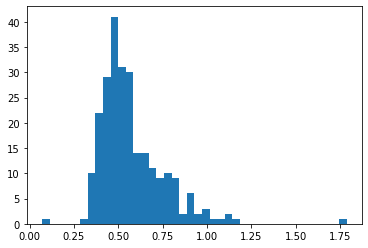

In [16]:
plt.hist(all_turn_max,bins=40);

In [9]:
from mpl_toolkits.axes_grid1 import ImageGrid

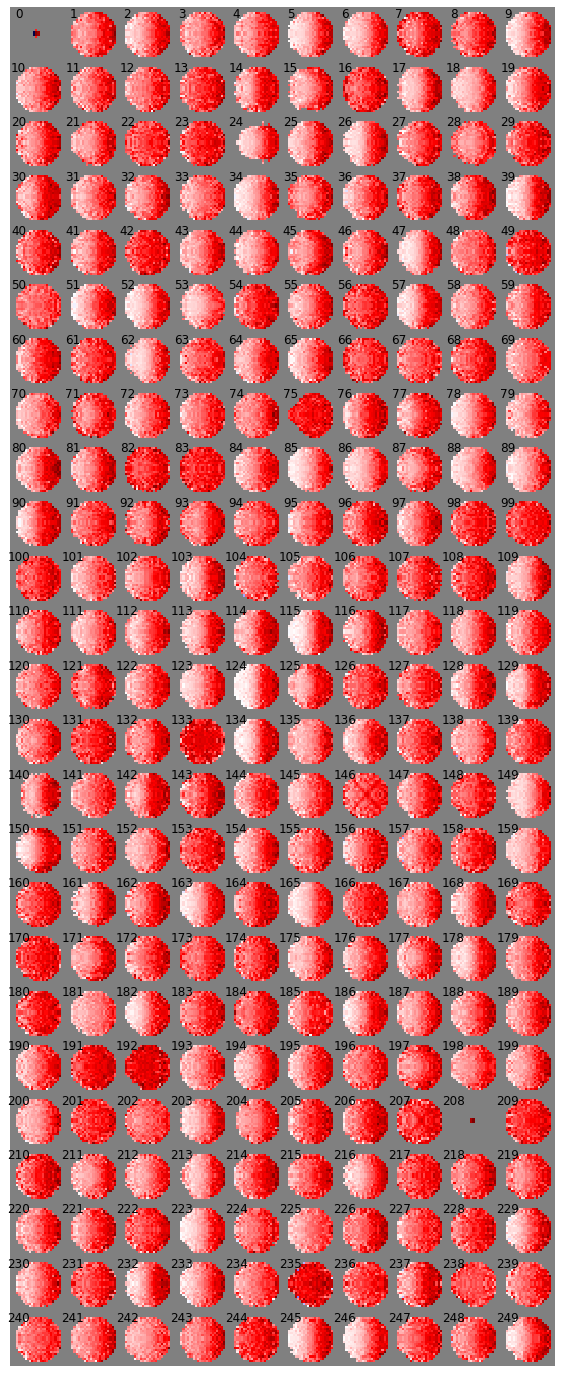

In [10]:
fig = plt.figure(figsize=(10,25))
grid = ImageGrid(fig, 111, nrows_ncols=(25, 10), axes_pad=0)

for i,ax in enumerate(grid):
    ax.imshow(all_fwd_hists[i],vmin=-1,vmax=1,cmap='seismic')
    ax.set_axis_off()
    ax.set_title(i,x=.15,y=.7)
    
# save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
# timestr = time.strftime("%Y%m%d-%H%M%S")
# fname = os.path.join(save_path, f'{timestr}')
# plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

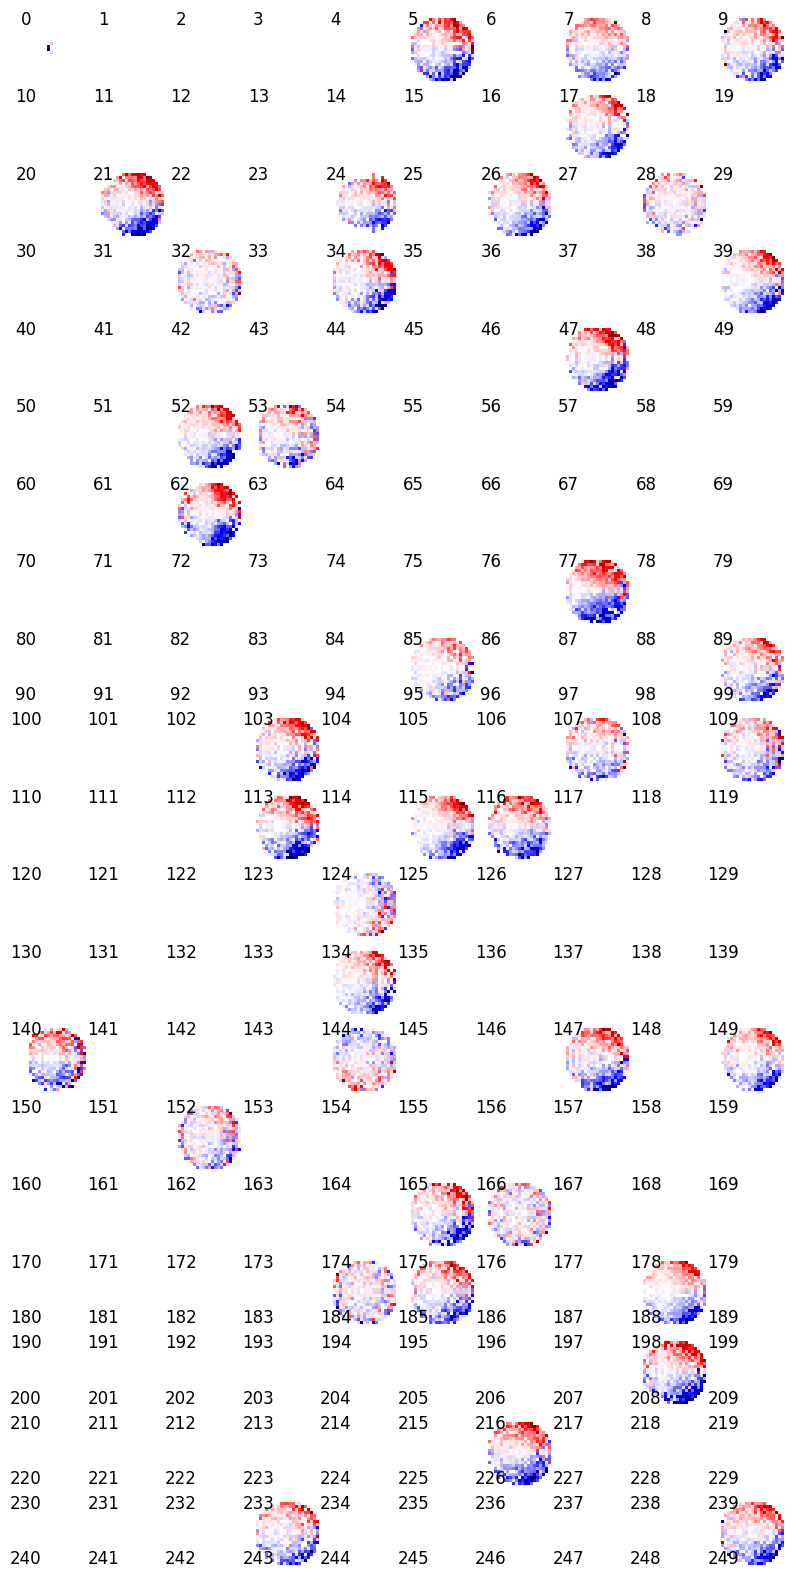

In [130]:
fig = plt.figure(figsize=(10,25))
grid = ImageGrid(fig, 111, nrows_ncols=(25, 10), axes_pad=0)

for i,ax in enumerate(grid):
    if all_turn_max[i] >.75:
        ax.imshow(all_turn_hists[i],vmin=-1,vmax=1,cmap='seismic')
    ax.set_axis_off()
    ax.set_title(i,x=.15,y=.7)
    
# save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
# timestr = time.strftime("%Y%m%d-%H%M%S")
# fname = os.path.join(save_path, f'{timestr}')
# plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

# correlate to ideal turn models

In [ ]:
# first make ideal models below, then run this code:

In [ ]:
binned_signal_ideal_independence
binned_signal_ideal_difference

In [14]:
corr_to_diff = []
corr_to_indep = []

for cluster in range(251):
    a = np.nan_to_num(all_turn_hists[cluster].flatten())
    b = np.nan_to_num(binned_signal_ideal_independence.flatten())
    
    r,p = scipy.stats.pearsonr(a, b)
    corr_to_indep.append(r)
    
    b = np.nan_to_num(binned_signal_ideal_difference.flatten())
    r,p = scipy.stats.pearsonr(a, b)
    corr_to_diff.append(r)

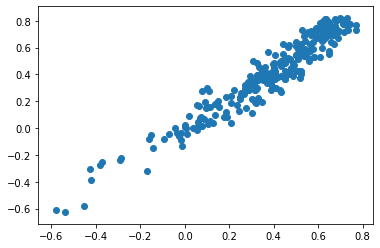

In [20]:
plt.scatter(corr_to_diff,corr_to_indep)

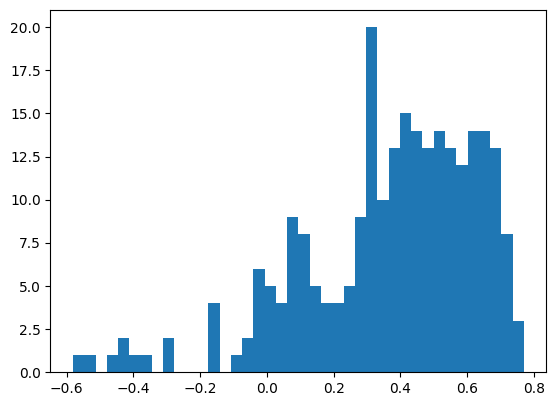

In [115]:
plt.hist(corr_to_diff,bins=40);

In [ ]:
### optional: add a threshold for masking out near-zero corrs
diff = np.asarray(corr_to_diff)-np.asarray(corr_to_indep)

# for i in range(len(diff)):
#     np.max()

In [124]:
visulize_clusters = np.zeros((314, 146, 91)) # last axis is for color
visulize_clusters[:] = np.nan
for cluster in range(251):
    if all_turn_max[cluster]>.75:
        color = diff[cluster]
    else:
        color=0
        
    #color = diff[cluster]
    visulize_clusters[np.where(superclusters_250==cluster)] = color

In [122]:
all_turn_hists

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


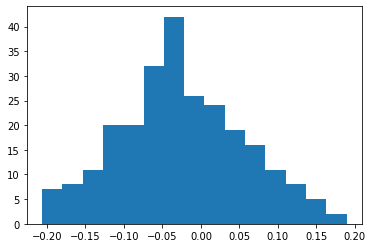

In [27]:
plt.hist(diff,bins=15);

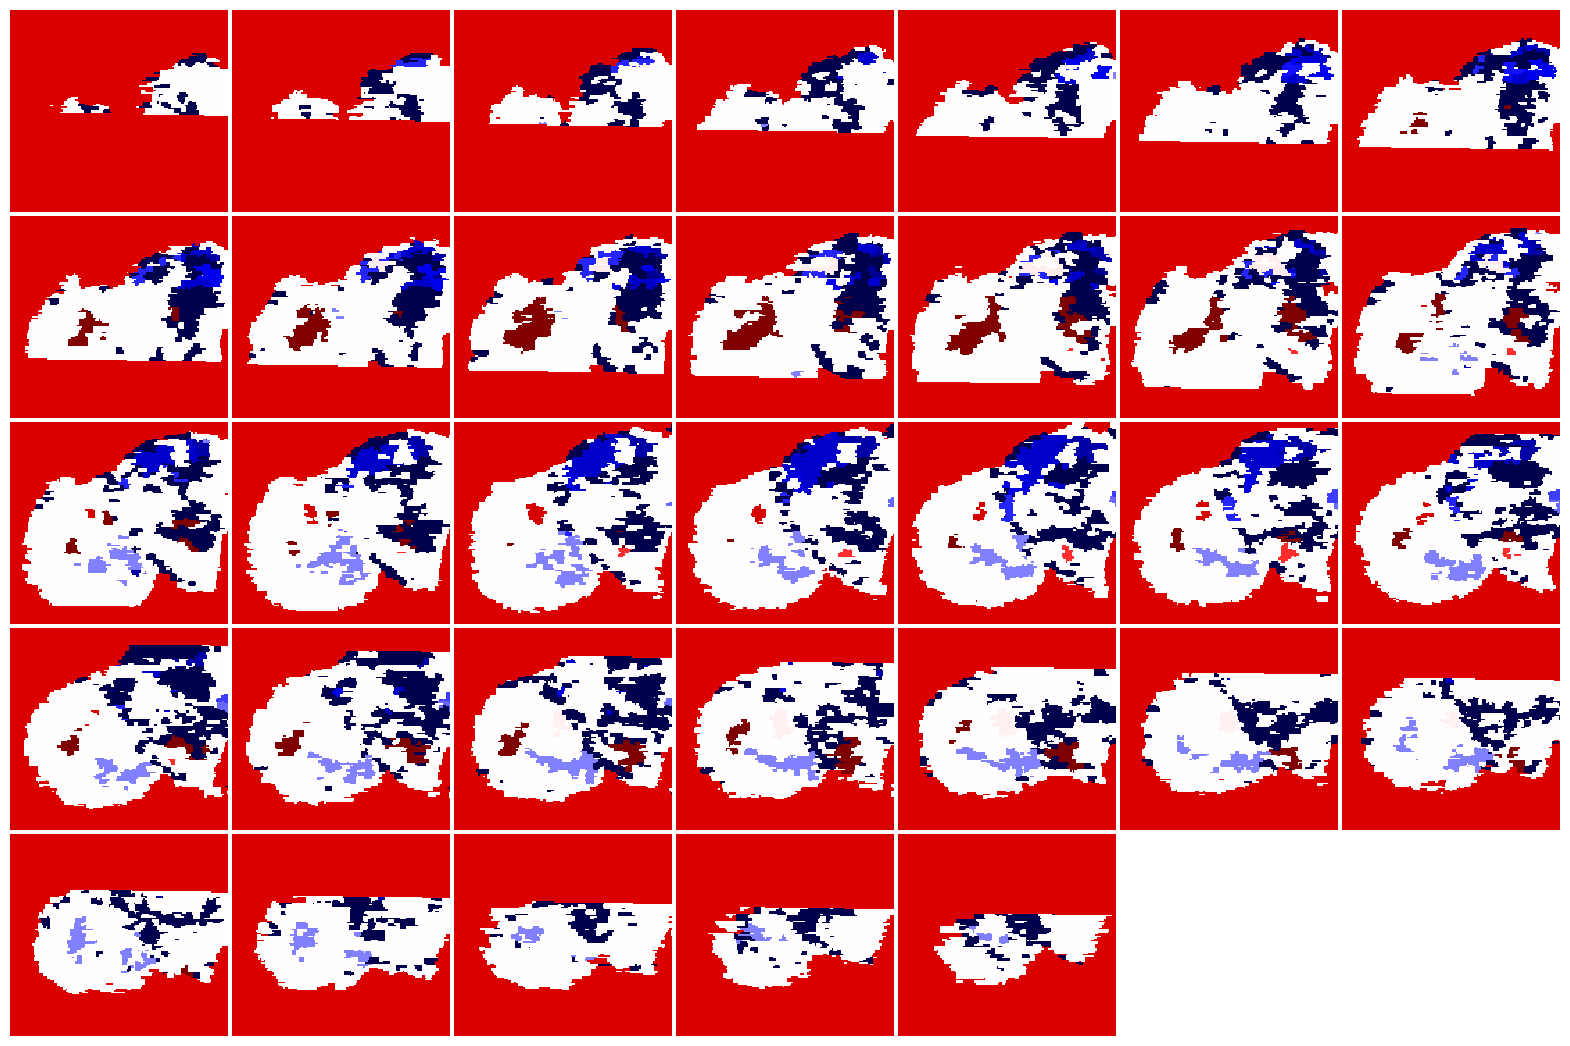

In [125]:
#here red prefers differnce in hemi

plt.figure(figsize=(20,20))
for j,z in enumerate(range(20,85,2)):
    plt.subplot(7,7,j+1)
    plt.imshow(np.swapaxes(visulize_clusters[:157,:,z],0,1),cmap='seismic',vmin=-.1,vmax=.1)
    plt.axis('off')
plt.subplots_adjust(wspace=0.02,hspace=-.25)

In [126]:
atlas = brainsss.load_roi_atlas()
import brainsss
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [127]:
input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
data_to_plot = visulize_clusters
vmax = 0.3
explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                    roi_masks,
                                                    roi_contours,
                                                    data_to_plot,
                                                    input_canvas,
                                                    vmax=vmax,
                                                    cmap='seismic',
                                                   diverging=True)#'hot')

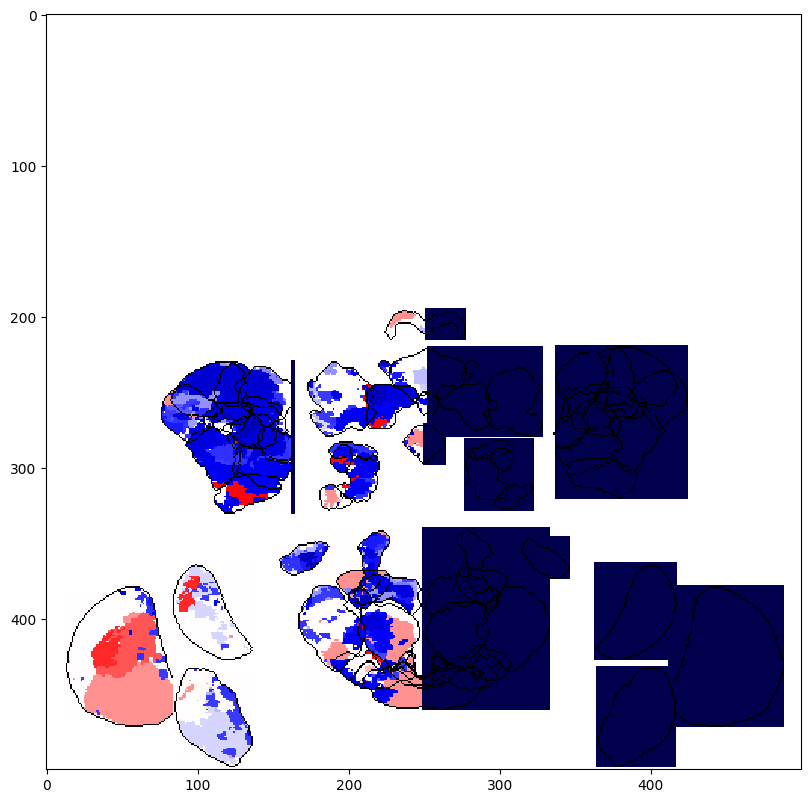

In [128]:
plt.figure(figsize=(10,10))
plt.imshow(explosion_map)

# DNa02 mask...

In [38]:
################
### Load FDA ###
################

def load_FDA():
    FDA_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20220301_luke_2_jfrc_affine.nii'
    FDA = np.asarray(nib.load(FDA_file).get_fdata().squeeze(), dtype='float32')
    FDA = ants.from_numpy(FDA)
    FDA.set_spacing((.38,.38,.38))
    FDA_lowres = ants.resample_image(FDA,(2.6,2.6,5),use_voxels=False)
    return FDA, FDA_lowres

FDA, FDA_lowres = load_FDA()

# hemibrain bounding box
start = {'x': 46, 'y': 5, 'z': 5}
stop = {'x': 147, 'y': 89, 'z': 34}

FDA_crop = FDA_lowres[start['x']:stop['x'],
                     start['y']:stop['y'],
                     start['z']:stop['z']]

In [40]:
FDA_lowres

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (241, 112, 36)
	 Spacing    : (2.6, 2.6, 5.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [45]:
turning_map = ants.from_numpy(visulize_clusters)
turning_map.set_spacing((2,2,2))
turning_map = ants.resample_image(turning_map,(2.6,2.6,5),use_voxels=False)
turning_map

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (242, 112, 36)
	 Spacing    : (2.6, 2.6, 5.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [46]:
turning_map_crop = turning_map[start['x']:stop['x'],
                     start['y']:stop['y'],
                     start['z']:stop['z']]

In [47]:
turning_map_crop.shape, FDA_crop.shape

((101, 84, 29), (101, 84, 29))

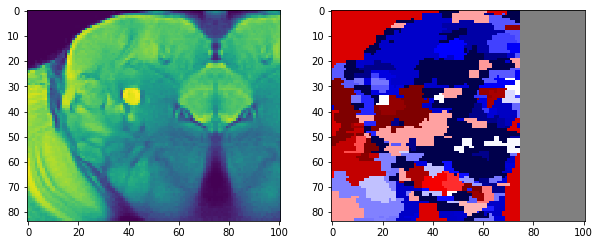

In [58]:
z=17
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(FDA_crop[:,:,z].T)
plt.subplot(122)
plt.imshow(turning_map_crop[:,:,z].T,cmap='seismic',vmin=-.1,vmax=.1)

In [60]:
connectome_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220624_supervoxels_in_FDA'

In [61]:
#############################
### load synapses and ids ###
#############################

file = os.path.join(connectome_dir,'hemibrain_all_neurons_synapses_polypre_centrifugal_synapses.pickle')
file = open(file, 'rb')
synapses = pickle.load(file)
cell_ids = np.unique(synapses['bodyid'])

In [62]:
#########################
### load cells in FDA ###
#########################

load_file = os.path.join(connectome_dir, 'synpervox.npy')
synpervox = np.load(load_file)

In [63]:
DNa02_R = "1140245595"
idx = np.where(cell_ids==DNa02_R)[0][0]
DNa02_mask = synpervox[idx,...].astype('float')

DNa02_mask[np.where(DNa02_mask<1)] = 0
DNa02_mask[np.where(DNa02_mask>1)] = 1

In [65]:
masked = turning_map_crop*DNa02_mask

In [ ]:
np.isnan(masked[np.nonzero(masked)])

In [101]:
a.shape

(84, 101)

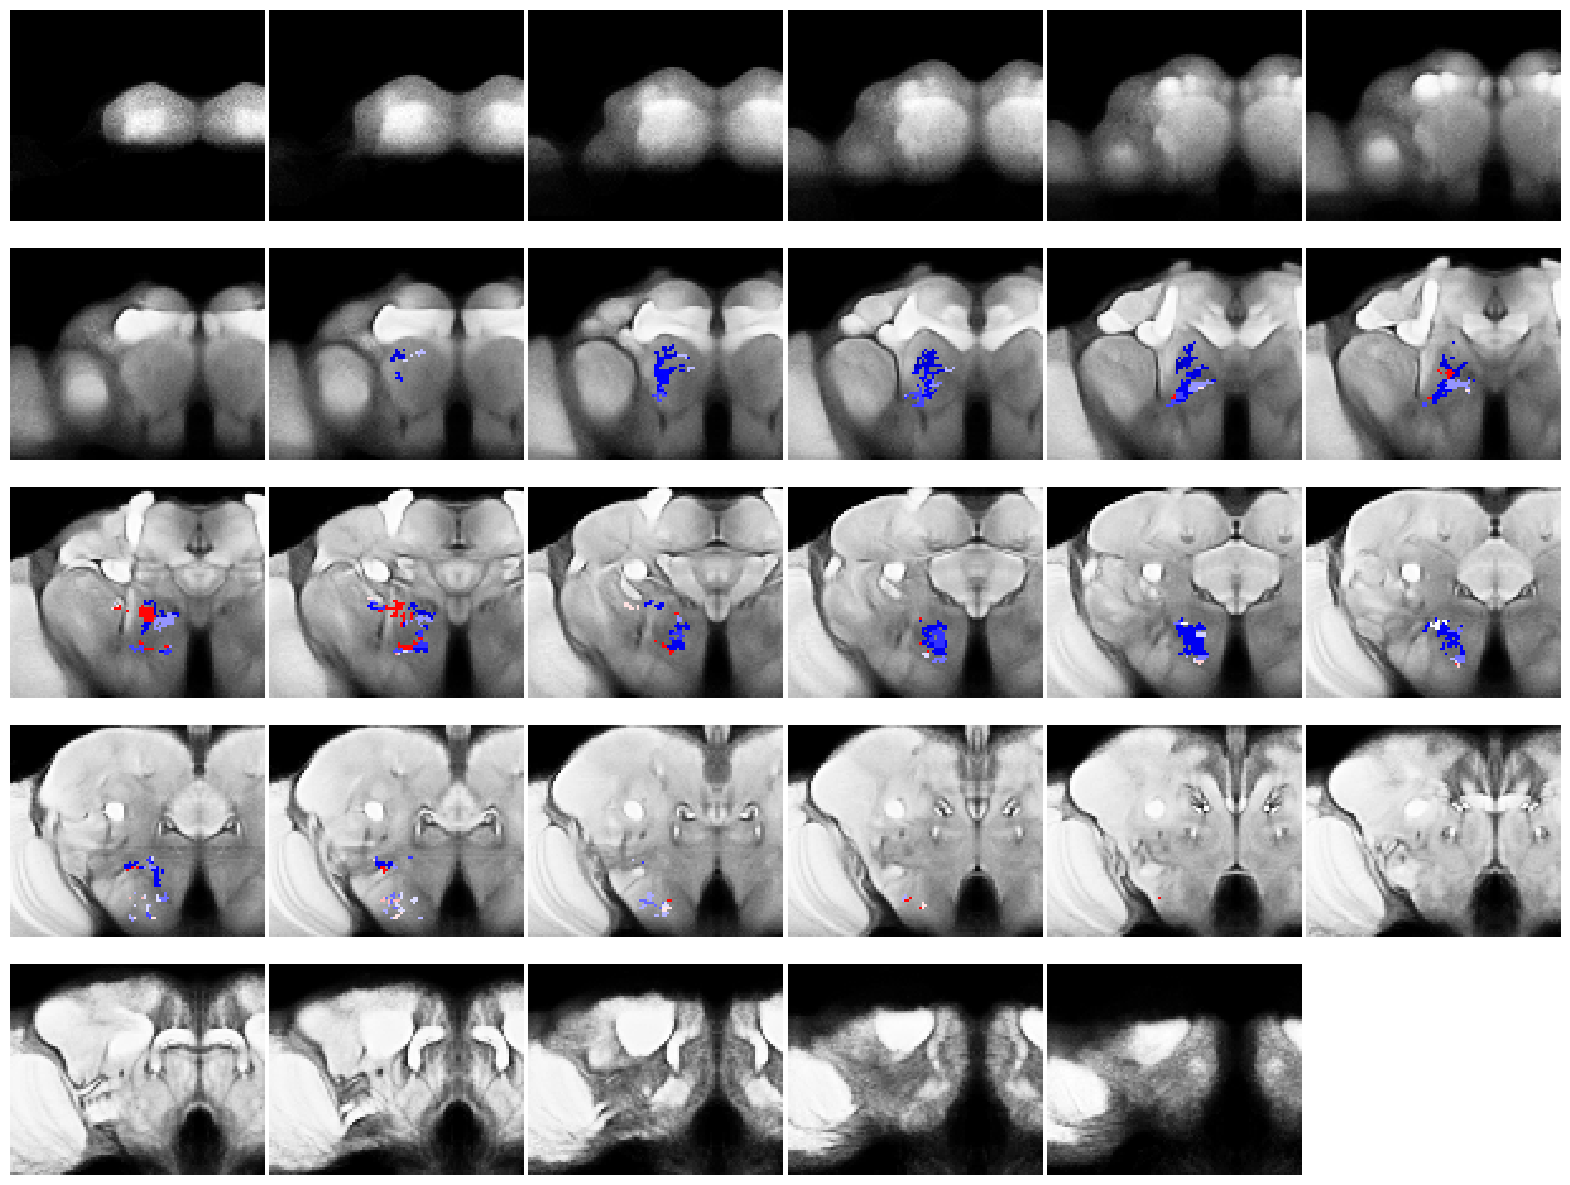

In [109]:
#here red prefers differnce in hemi
cmap = plt.cm.get_cmap("seismic")
cmap.set_bad(color='k', alpha=0)

plt.figure(figsize=(20,20))
for j,z in enumerate(range(29)):
    plt.subplot(6,6,j+1)
    plt.imshow(FDA_crop[:,:,z].T,cmap='Greys_r')
    a = np.nan_to_num(masked[:,:,z].T)
    a[a==0] = np.nan
    plt.imshow(a[:,:],cmap=cmap,vmin=-.3,vmax=.3)
    plt.axis('off')
plt.subplots_adjust(wspace=0.02,hspace=-.25)

array([False, False, False, ...,  True,  True,  True])

In [ ]:
DNa02_R = "1140245595"
idx = np.where(cell_ids==DNa02_R)[0][0]
DNa02_mask = synpervox[idx,...].astype('float')
DNa02_mask[np.where(DNa02_mask<10)] = np.nan

fig = plt.figure(figsize=(20,10))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 5), axes_pad=.05)
for z in range(29):
    grid[z].imshow(FDA_crop[:,:,z].T,cmap='Greys_r')
    grid[z].imshow(filters_[:,:,z,tp].T,cmap='hot',vmin=0,vmax=2)
    grid[z].imshow(DNa02_mask[:,:,z].T,cmap='Blues',vmin=0,vmax=1)

In [8]:
# just inject gaussian noise into the behavior...

np.random.seed(0)
noise1 = np.random.normal(0,1,len(beh_turn))
np.random.seed(1)
noise2 = np.random.normal(0,1,len(beh_turn))

Text(0.5, 0, 'Right ROI signal')

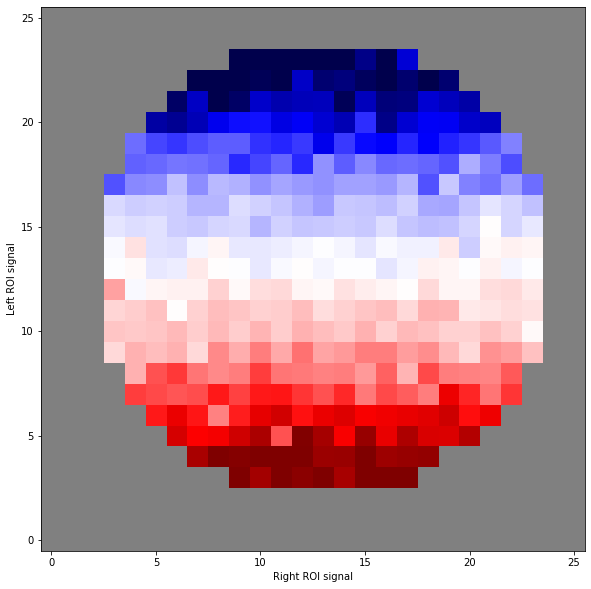

In [11]:
plt.figure(figsize=(10,10))

# x_data = noise1 + np.clip(beh_turn,0,None)
# y_data = noise2 - np.clip(beh_turn,None,0)

x_data = noise1 + beh_turn
y_data = noise2 - beh_turn

r = np.deg2rad(45)
rot = [[np.cos(r),-np.sin(r)],[np.sin(r),np.cos(r)]]
m = np.vstack((x_data,y_data)).T
out = np.matmul(m,rot)
x_data = out[:,1]; y_data = out[:,0]

behavior = beh_turn

x_data /= np.std(x_data)/0.2
y_data /= np.std(y_data)/0.2

start=-.6
stop=.6
num_bins=40
min_num_samples=10

# Define bins
bins = np.linspace(start,stop,num_bins)

# Assign neural values to bin numbers
idx_x, idx_y = np.digitize(x_data,bins), np.digitize(y_data,bins)

binned_signal_ideal = []
sample_count = []
for i in range(num_bins):
    mask_x = (idx_x == i)
    for j in range(num_bins):
        mask_y = (idx_y == j)
        mask = mask_x & mask_y

        binned_signal_ideal.append(np.mean(behavior[mask]))
        sample_count.append(np.count_nonzero(~np.isnan(behavior[mask])))

binned_signal_ideal = np.reshape(binned_signal_ideal,(num_bins, num_bins))
sample_count = np.reshape(sample_count,(num_bins, num_bins))

# Hide bins containing too few data points
binned_signal_ideal[np.where(sample_count<=min_num_samples)] = np.nan


#mask a circle
radius = 11
#binned_signal *= make_circle_aperture(num_bins,radius)
aperture = make_circle_aperture(num_bins,radius)
aperture[aperture==0]=np.nan
binned_signal_ideal*=aperture

#crop
binned_signal_ideal = binned_signal_ideal[7:-7,7:-7]

#normalize
binned_signal /= np.max(np.nan_to_num(binned_signal_ideal))

cmap = plt.cm.get_cmap("seismic")
cmap.set_bad(color='grey')
plt.imshow(binned_signal_ideal,vmin=-1,vmax=1,cmap=cmap,origin='lower')
plt.ylabel('Left ROI signal')
plt.xlabel('Right ROI signal')
#plt.plot([0,25],[0,25],color='k')
#plt.colorbar()
#plt.ylim(0,30)
#plt.xlim(0,30)
#plt.title("TURN INDEPENDENCE MODEL")
#plt.suptitle(F"Clusters {cluster_}, {cluster_+250}",y=.72)

In [12]:
binned_signal_ideal_difference = binned_signal_ideal

In [10]:
binned_signal_ideal_independence = binned_signal_ideal

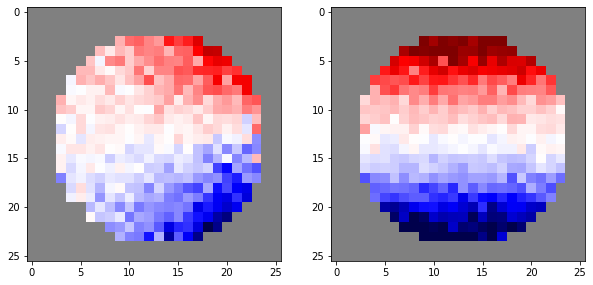

In [13]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(binned_signal_ideal_independence,cmap='seismic',vmin=-1,vmax=1)
plt.subplot(1,2,2)
plt.imshow(binned_signal_ideal_difference,cmap='seismic',vmin=-1,vmax=1)

# Cluster

In [359]:
all_turn_hists = np.asarray(all_turn_hists)
all_turn_hists.shape

(251, 26, 26)

In [360]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from matplotlib import colors

In [411]:
to_cluster = np.nan_to_num(np.reshape(all_turn_hists,(251,26*26)))
to_cluster.shape

(251, 676)

In [494]:
t0 = time.time()
print('clustering.........')
model = AgglomerativeClustering(distance_threshold=0, #first run with =0. Then change to None
                                n_clusters=None, #and with n_clusters =None. Then change to n_clusters
                                memory=cluster_dir,
                                linkage='ward')
model = model.fit(to_cluster)
print('complete!')
print(time.time()-t0)

clustering.........
complete!
0.03098750114440918


In [495]:
### Create linkage matrix for dendrogram

counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([model.children_, model.distances_,
                                  counts]).astype(float)

In [496]:
n_clusters = 5

### Given a desired # of clusters, grab the distance threshold - needed for dendrogram
thresh = model.distances_[-n_clusters+1]

### Create the same # of colors as # of clusters
custom_cmap = cm.gist_ncar(np.linspace(0.1, 0.95, n_clusters))
cluster_colors = [colors.rgb2hex(rgb[:3]) for rgb in custom_cmap]
hierarchy.set_link_color_palette(cluster_colors[::-1])

### Grab the cluster ids
cluster_ids = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
cluster_ids -= 1 #make 0 index

cluster_colors_for_brain = cluster_colors[:]
#cluster_colors_for_brain.insert(0,'grey')
cmap = colors.ListedColormap(cluster_colors_for_brain)

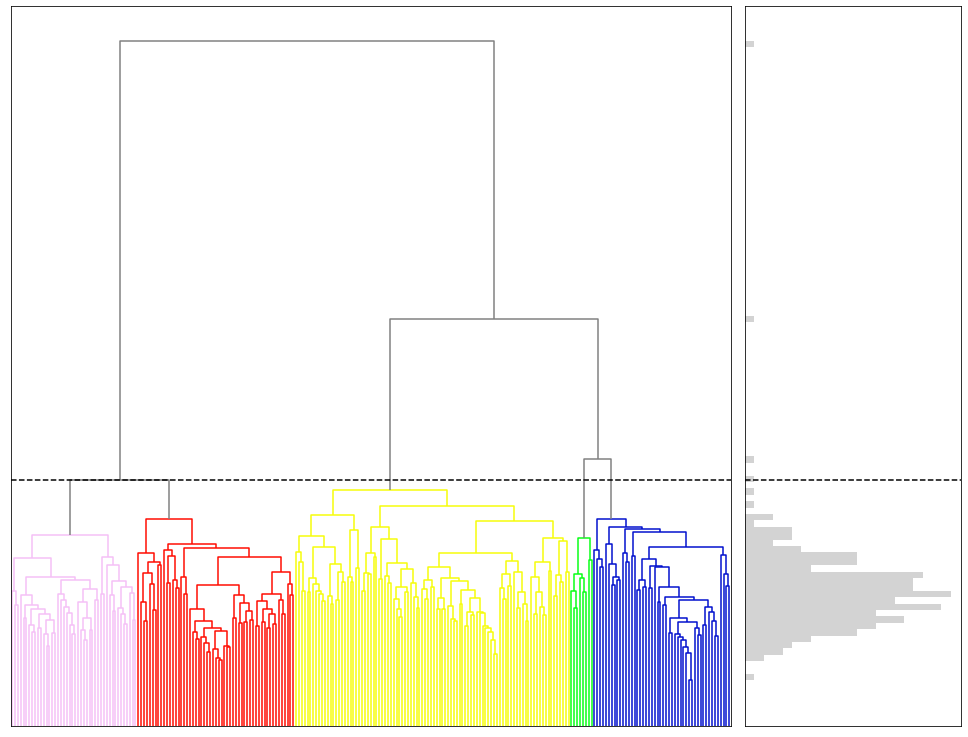

In [497]:
fig = plt.figure(figsize=(10,10))
background_color = '#D3D3D3'

ax_dendrogram = fig.add_axes([1.1, 0, 1, 1])
ax_dendrogram.get_xaxis().set_visible(False)
ax_dendrogram.get_yaxis().set_visible(False)
dendrogram(linkage_matrix,
           truncate_mode=None,
           p=0,
           color_threshold=thresh,
           no_labels=True,
           distance_sort=True,
           above_threshold_color='grey');
try:
    plt.axhline(linkage_matrix[251-n_clusters,2],color='k',linestyle='--')
except:
    print('axhline failed')

ax_dend_hist = fig.add_axes([2.12, 0, .3, 1],sharey=ax_dendrogram)
ax_dend_hist.hist(linkage_matrix[:,2],bins=100,orientation='horizontal',color=background_color);
try:
    ax_dend_hist.axhline(linkage_matrix[251-n_clusters,2],color='k',linestyle='--')
except:
    print('axhline failed')
ax_dend_hist.get_xaxis().set_visible(False)
ax_dend_hist.get_yaxis().set_visible(False)

In [498]:
t0 = time.time()
print('clustering.........')
model = AgglomerativeClustering(distance_threshold=None, #first run with =0. Then change to None
                                n_clusters=n_clusters, #and with n_clusters =None. Then change to n_clusters
                                memory=cluster_dir,
                                linkage='ward')
model = model.fit(to_cluster)
print('complete!')
print(time.time()-t0)

clustering.........
complete!
0.012481689453125


In [499]:
cluster_hists = []
for label in np.unique(cluster_ids):
    print(label)
    ind = np.where(cluster_ids==label)[0]
    cluster_hists.append(np.mean(np.nan_to_num(all_turn_hists)[ind,...],axis=0))

0
1
2
3
4


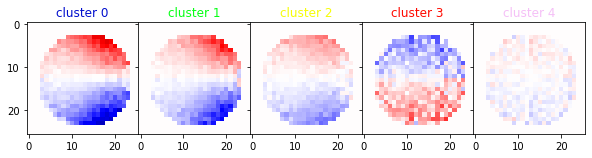

In [500]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(1, n_clusters), axes_pad=0)

for i,ax in enumerate(grid):
    ax.imshow(cluster_hists[i],vmin=-1,vmax=1,cmap='seismic')
    ax.set_title(F"cluster {i}",color=cluster_colors[i])

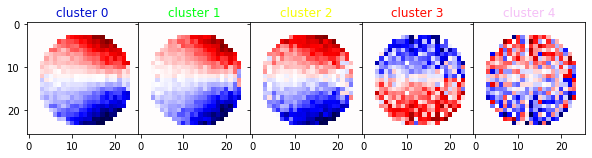

In [486]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(1, n_clusters), axes_pad=0)

for i,ax in enumerate(grid):
    max_v = np.max(cluster_hists[i])
    ax.imshow(cluster_hists[i],vmin=-max_v,vmax=max_v,cmap='seismic')
    ax.set_title(F"cluster {i}",color=cluster_colors[i])

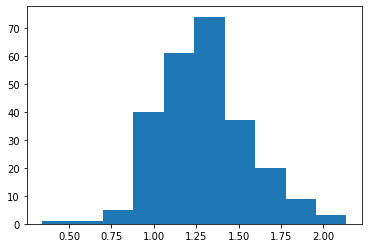

In [472]:
plt.hist(all_fwd_max);

In [483]:
visulize_clusters = np.zeros((314, 146, 91, 4)) # last axis is for color
visulize_clusters[:] = np.nan
for cluster in range(251):
    alpha = all_fwd_max[cluster]/np.max(all_fwd_max)
    color = custom_cmap[cluster_ids[cluster],:]
    color[3] = alpha
    visulize_clusters[np.where(superclusters_250==cluster)] = color
        

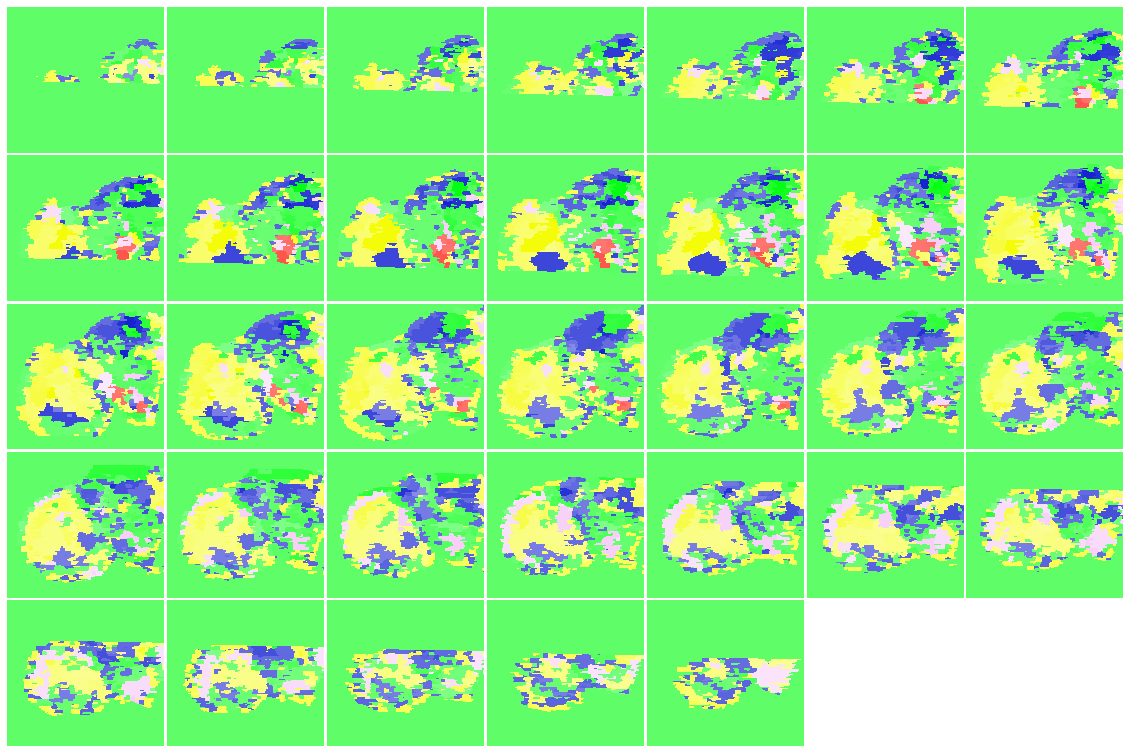

In [485]:
plt.figure(figsize=(20,20))
for j,z in enumerate(range(20,85,2)):
    plt.subplot(7,7,j+1)
    plt.imshow(np.swapaxes(visulize_clusters[:157,:,z,:],0,1))
    plt.axis('off')
plt.subplots_adjust(wspace=0.02,hspace=-.25)

In [449]:
visulize_clusters = np.zeros((314, 146, 91))
for cluster in range(251):
    visulize_clusters[np.where(superclusters_250==cluster)] = cluster_ids[cluster]+1

In [445]:
cluster_colors_for_brain = cluster_colors[:]
cluster_colors_for_brain.insert(0,'grey')
cmap = colors.ListedColormap(cluster_colors_for_brain)

In [450]:
temporal_map = visulize_clusters

In [451]:
input_canvas = np.zeros((500,500))

x_shift=0; y_shift=0
data_map, contours = plot_grouped_roi_image(FB_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=-45
data_map, contours = plot_grouped_roi_image(PB.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=35
data_map, contours = plot_grouped_roi_image({23: 'EB'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##########
### MB ###
##########

# x_shift=60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_left_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
# x_shift=-60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_right_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

#################
### BIG GROUP ###
#################

x_shift=-130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_r_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_l_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##############
### VISUAL ###
##############

x_shift=-200; y_shift=175
data_map, contours = plot_grouped_roi_image({25: 'MED_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=200; y_shift=175
data_map, contours = plot_grouped_roi_image({71: 'MED_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({3: 'LO_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({53: 'LO_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({22: 'LP_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({69: 'LP_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

canvas = wraper_wraper(canvas, ventromedial_r_group.keys(), y_shift=55, x_shift=-50)
canvas = wraper_wraper(canvas, ventromedial_l_group.keys(), y_shift=55, x_shift=50)

canvas = wraper_wraper(canvas, anterior_group.keys(), y_shift=150, x_shift=0)

canvas = wraper_wraper(canvas, {34: 'AOTU_R'}.keys(), y_shift=-50+175-15, x_shift=-80)
canvas = wraper_wraper(canvas, {79: 'AOTU_L'}.keys(), y_shift=-50+175-15, x_shift=80)

canvas[np.where(canvas==0)] = np.nan

(-0.5, 499.5, 349.5, -0.5)

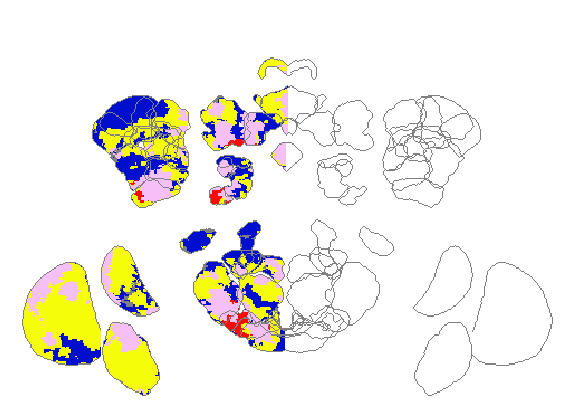

In [452]:
plt.figure(figsize=(10,10))
plt.imshow(canvas[150:,:],cmap=cmap)
plt.axis('off')

In [439]:
import brainsss
atlas_clean = brainsss.load_roi_atlas()
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas_clean)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas_clean)

In [440]:
def plot_grouped_roi_image(rois,plot=True):
    roi_data = []
    roi_contours = []

    left_edges = []
    right_edges = []
    bottom_edges = []
    top_edges = []

    for roi in rois:
        ####################
        ### Get roi mask ###
        ####################

        mask = np.zeros(atlas_clean.shape)
        mask[np.where(atlas_clean == roi)] = 1

        mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
        mask_dilated = binary_dilation(mask_eroded, iterations=2)

        # temporal
        masked_roi = mask_dilated*temporal_map #CORR
        masked_roi_flat = np.max(masked_roi,axis=2)
        roi_data.append(masked_roi_flat)
        
        #PCA
#         masked_roi = mask_dilated*pca_map
#         maxs = np.max(masked_roi,axis=2)
#         mins = np.min(masked_roi,axis=2)
#         maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
#         masked_roi_flat = maxs
#         roi_data.append(masked_roi_flat)
    
        #######################
        ### Get roi contour ###
        #######################
        
        _, mask_binary = cv2.threshold(np.max(mask_dilated,axis=-1).astype('uint8'), 0, 1, cv2.THRESH_BINARY) 
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#cv2.RETR_TREE

        canvas = np.ones(atlas_clean[:,:,0].shape)
        out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
        out = np.abs(out-1) #flip 0/1
        roi_contour = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white
        roi_contours.append(roi_contour)

        # for plotting
        left_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][0])
        right_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][-1])
        top_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][0])
        bottom_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][-1])
        
    # get extreme edges from all rois used
    left_edge = np.min(left_edges) - 1
    right_edge = np.max(right_edges) + 1
    top_edge = np.min(top_edges) - 1
    bottom_edge = np.max(bottom_edges) + 1

    ############
    ### PLOT ###
    ############
    
    roi_datas = np.max(np.asarray(roi_data),axis=0)
    data_map = np.swapaxes(roi_datas[top_edge:bottom_edge,left_edge:right_edge],0,1)
    
    #PCA
#     roi_data = np.asarray(roi_data)
#     maxs = np.max(roi_data,axis=0)
#     mins = np.min(roi_data,axis=0)
#     maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
#     data_map = np.swapaxes(maxs[top_edge:bottom_edge,left_edge:right_edge],0,1)

    if plot:
        plt.figure(figsize=(10,10))
        plt.imshow(data_map)

    contours_to_export = []
    for i in range(len(roi_contours)):
        single_contour = np.swapaxes(roi_contours[i][top_edge:bottom_edge,left_edge:right_edge],0,1)
        contours_to_export.append(single_contour)
        if plot:
            plt.imshow(single_contour)
        
    return data_map, contours_to_export

def place_on_canvas(input_canvas, to_plot, is_contour=False, is_midline=True, x_shift=0, y_shift=0):
    full_y_mid = int(input_canvas.shape[0]/2)
    full_x_mid = int(input_canvas.shape[1]/2)

    y_mid = int(to_plot.shape[0]/2)
    x_mid = int(to_plot.shape[1]/2)

    height = to_plot.shape[0]
    width = to_plot.shape[1]

    left = full_x_mid-x_mid
    right = left + width

    top = full_y_mid-y_mid
    bottom = top + height

    if is_contour:
        ys = np.where(to_plot[:,:,0]>0)[0] + full_y_mid - y_mid + y_shift
        xs = np.where(to_plot[:,:,0]>0)[1] + full_x_mid - x_mid + x_shift
        input_canvas[ys,xs]=1
    else:
        #input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift,:3] = to_plot
        input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift] = to_plot #pca
    return input_canvas

def place_on_canvas_wrapper(canvas, data_map, contours, y_shift, x_shift):
    canvas = place_on_canvas(canvas, to_plot=data_map, y_shift=y_shift, x_shift=x_shift)
    for i in range(len(contours)):
        canvas = place_on_canvas(canvas, to_plot=contours[i], is_contour=True, y_shift=y_shift, x_shift=x_shift)
    return canvas

def wraper_wraper(canvas, roi_ids, y_shift, x_shift):
    data_map, contours = plot_grouped_roi_image(roi_ids, plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    return canvas

In [441]:
##################
### ROI GROUPS ###
##################

FB_group = {
26: 'FB',
4: 'NO',
5: 'BU_R',
54: 'BU_L',
8: 'LAL_R',
56: 'LAL_L',
31: 'PVLP_R',
76: 'PVLP_L'}

ventromedial_r_group = {
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
11: 'AMMC_R'}

ventromedial_l_group = {
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
58: 'AMMC_L'}

PB = {6: 'PB'}
EB = {23: 'EB'}

anterior_group = {
50: 'PRW',
9: 'SAD',
49: 'GNG',
30: 'AVLP_R',
75: 'AVLP_L',
24: 'AL_R',
70: 'AL_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
32: 'IVLP_R',
77: 'IVLP_L',
10: 'CAN_R',
20: 'FLA_R',
57: 'CAN_L',
67: 'FLA_L'}

big_r_group = {
27: 'SLP_R',
29: 'SMP_R',
33: 'PLP_R',
7: 'LH_R',
38: 'IPS_R',
37: 'SPS_R',
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',
28: 'SIP_R'}
    
big_l_group = {
72: 'SLP_L',   
74: 'SMP_L',
78: 'PLP_L',
55: 'LH_L',
83: 'IPS_L',
82: 'SPS_L',
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',
73: 'SIP_L'}

In [307]:
img = make_circle_aperture(num_bins,radius)
img[img==0]=np.nan

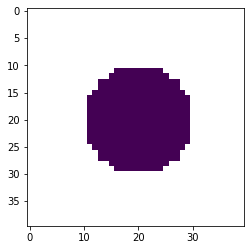

In [309]:
plt.imshow(img)

In [297]:
aperture

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [229]:
binned_signal.shape

(25, 25)

In [203]:
np.std(x_data), np.std(y_data)

(0.15000000000000002, 0.15)

In [105]:
np.std(x_data)/np.std(x_data)*0.15

0.15

In [ ]:
# if we want to fix stddev at 0.15
# 0.15 = np.std(x_data)

In [102]:
# how to turn 0.1 into 0.15?
.1*1.5

0.15000000000000002

In [ ]:
#can turn 

In [73]:
np.std(y_data)/np.std(x_data)

2.5200133472319686

In [153]:
# if my goal is to cluster these, I would need to normalize/stretch the 
# orthogonal axis
# how the fuck do I do that? basically need to decorrelate
from scipy.spatial.transform import Rotation as R

In [155]:
r = R.from_euler('xyz', [0,0,1], degrees=True).as_dcm()
r
#data_r = np.matmul(data.T,r).T

array([[ 0.9998477 , -0.01745241,  0.        ],
       [ 0.01745241,  0.9998477 ,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [144]:
cluster_= 47
x_data = supercluster_signals[cluster_,:]
y_data = supercluster_signals[cluster_+250,:]

r, p = scipy.stats.pearsonr(x_data, y_data)
r

0.7274073457795311

In [145]:
r, p = scipy.stats.pearsonr(x_data, y_data-x_data)
r

-0.322735058362842

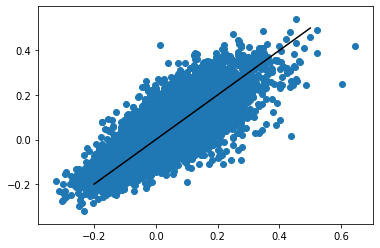

In [149]:
plt.scatter(x_data,y_data)
plt.plot([-.2,.5],[-.2,.5],color='k')

In [151]:
m = np.vstack((x_data,y_data)).T
m.shape

(30456, 2)

In [164]:
r = np.deg2rad(45)
rot = [[np.cos(r),-np.sin(r)],[np.sin(r),np.cos(r)]]
rot

[[0.7071067811865476, -0.7071067811865475],
 [0.7071067811865475, 0.7071067811865476]]

In [165]:
out = np.matmul(m,rot)

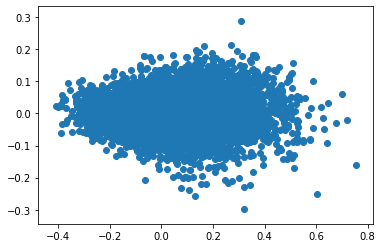

In [167]:
plt.scatter(out[:,0],out[:,1])

In [ ]:
#if y=mx+b
#all we have to do it subtract x from y

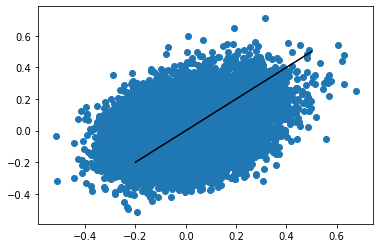

In [32]:
plt.scatter(x_data+noise1,y_data+noise2)
plt.plot([-.2,.5],[-.2,.5],color='k')

In [31]:
np.random.seed(0)
noise1 = np.random.normal(0,.1,len(x_data))
np.random.seed(1)
noise2 = np.random.normal(0,.1,len(x_data))

In [41]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import pearsonr

A = x_data
B = y_data

print(f'Original correlation: {pearsonr(A, B)[0]}')

array = np.zeros((A.size, 2))
array[:, 0] = A
array[:, 1] = B

# step 1: scale both variables
scaled_array = StandardScaler().fit_transform(array)

# PCA decomposition
model = PCA()
pca = model.fit_transform(scaled_array)  # fit the model

print(f'New correlation: {pearsonr(pca[:, 0], pca[:, 1])[0]}')

Original correlation: 0.7274073457795311
New correlation: -3.726262439859021e-16


In [44]:
scaled_array.shape

(30456, 2)

In [56]:
model.get_covariance()

array([[0.005639  , 0.00426658],
       [0.00426658, 0.00610101]])

In [59]:
model = PCA()
pca = model.fit(np.vstack((x_data,y_data)).T)

In [62]:
dir(pca)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_fit',
 '_fit_full',
 '_fit_svd_solver',
 '_fit_truncated',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 'components_',
 'copy',
 'explained_variance_',
 'explained_variance_ratio_',
 'fit',
 'fit_transform',
 'get_covariance',
 'get_params',
 'get_precision',
 'inverse_transform',
 'iterated_power',
 'mean_',
 'n_components',
 'n_components_',
 'n_features_',
 'n_samples_',
 'noise_variance_',
 'random_state',
 'score',
 'score_samples',
 'set_params',
 'singular_values

In [67]:
pca.explained_variance_[0]/pca.explained_variance_[1]

1.5876168175568175

In [60]:
plt.scatter(pca[:, 0], pca[:, 1])

TypeError: 'PCA' object is not subscriptable

In [42]:
len(pca[:, 0])

30456

# modeling fake data...

In [ ]:
### lets try to make toy data for two different forward encodings:
#1) the sum of hemis encodes forward
#2) each hemi independently encodes forward

In [3]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"

In [4]:
# lets make a behavior trace
# actually may as well use the real behavior...
file = os.path.join(cluster_dir,"20221122_behavior_fwd.npy")
beh_fwd = np.load(file)
print(beh_fwd.shape)

(30456,)


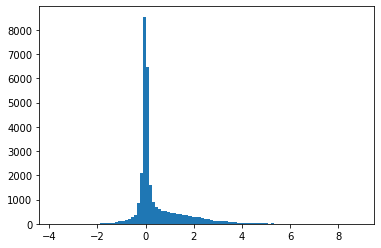

In [6]:
plt.hist(beh_fwd,bins=100);

In [ ]:
## now lets generate fake neural data to match each hypothesis

In [ ]:
## independent signals is easiest - just generate two separate traces

In [96]:
# just inject gaussian noise into the behavior...

np.random.seed(0)
noise1 = np.random.normal(0,1,len(beh_fwd))
np.random.seed(1)
noise2 = np.random.normal(0,1,len(beh_fwd))
np.random.seed(2)
noise3 = np.random.normal(0,1,len(beh_fwd))

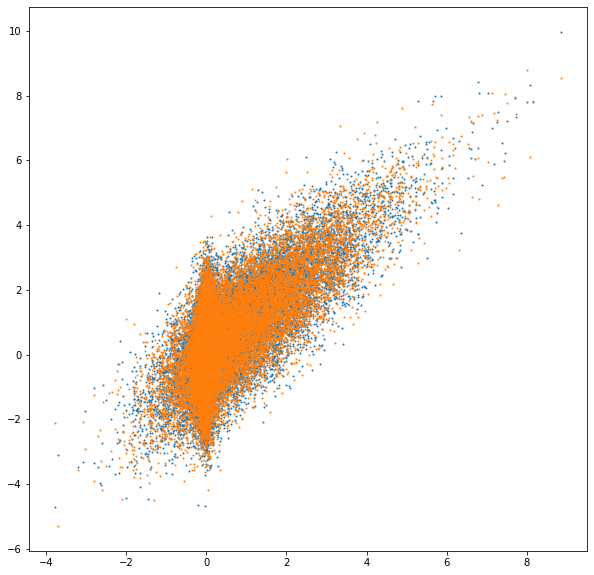

In [13]:
plt.figure(figsize=(10,10))
plt.scatter(beh_fwd, beh_fwd+noise1,s=1)
plt.scatter(beh_fwd, beh_fwd+noise2,s=1)

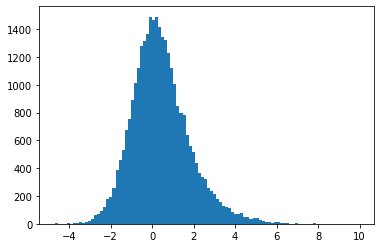

In [14]:
plt.hist(beh_fwd+noise1,bins=100);

Text(0.5, 1.0, 'FWD INDEPENDENT MODEL')

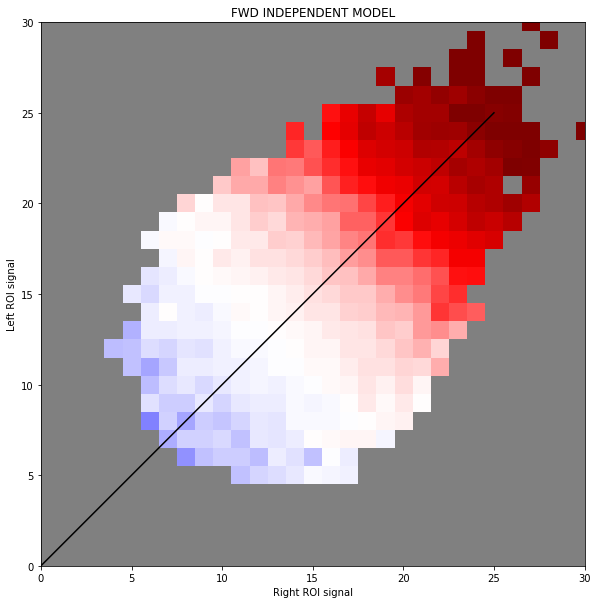

In [129]:
plt.figure(figsize=(10,10))

x_data = beh_fwd+noise1
y_data = beh_fwd+noise2
behavior = beh_fwd

start=-4
stop=8
num_bins=40
min_num_samples=10

# Define bins
bins = np.linspace(start,stop,num_bins)

# Assign neural values to bin numbers
idx_x, idx_y = np.digitize(x_data,bins), np.digitize(y_data,bins)

binned_signal = []
sample_count = []
for i in range(num_bins):
    mask_x = (idx_x == i)
    for j in range(num_bins):
        mask_y = (idx_y == j)
        mask = mask_x & mask_y

        binned_signal.append(np.mean(behavior[mask]))
        sample_count.append(np.count_nonzero(~np.isnan(behavior[mask])))

binned_signal = np.reshape(binned_signal,(num_bins, num_bins))
sample_count = np.reshape(sample_count,(num_bins, num_bins))

# Hide bins containing too few data points
binned_signal[np.where(sample_count<=min_num_samples)] = np.nan

cmap = plt.cm.get_cmap("seismic")
cmap.set_bad(color='grey')
plt.imshow(binned_signal,vmin=-3,vmax=3,cmap=cmap,origin='lower')
plt.ylabel('Left ROI signal')
plt.xlabel('Right ROI signal')
plt.plot([0,25],[0,25],color='k')
#plt.colorbar()
plt.ylim(0,30)
plt.xlim(0,30)
plt.title("FWD INDEPENDENT MODEL")
#plt.suptitle(F"Clusters {cluster_}, {cluster_+250}",y=.72)

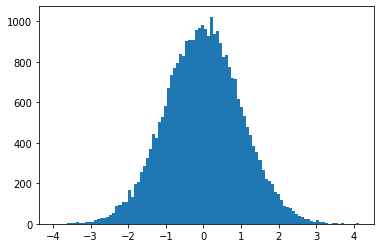

In [24]:
plt.hist(noise3,bins=100);

In [77]:
### how to model the sum model?

#need to turn the behavior into two vectors that end up summing to the behavior.
hemi1 = beh_fwd+noise3+noise1
hemi3 = beh_fwd-noise3+noise2

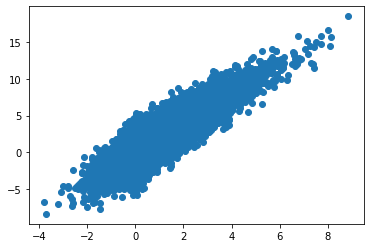

In [80]:
plt.scatter(beh_fwd,hemi1+hemi3);

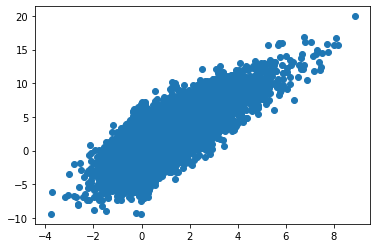

In [165]:
### FWD SUM MODEL ###

x_data = beh_fwd + noise1
y_data = beh_fwd + noise1
plt.scatter(beh_fwd,x_data+y_data)

In [ ]:
### lets consider a few points
# (a,b) -> c
# (9,1) -> 10
# (1,9) -> 10
# (5,5) -> 10
# (2,6) -> 8

# if a=noise, then b could be behavior-noise
# only problem here is b will be larger on average


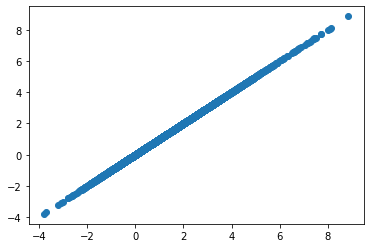

In [184]:
### FWD SUM MODEL ###

x_data = (beh_fwd*0.5) + noise1
y_data = (beh_fwd*0.5) - noise1
plt.scatter(beh_fwd,x_data+y_data)

In [185]:
np.mean(x_data), np.mean(y_data)

(0.2108566376914263, 0.2193363638012058)

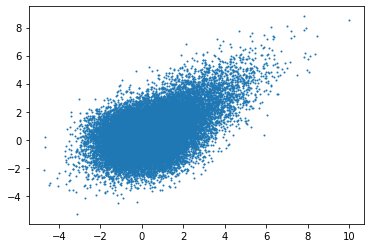

In [196]:
plt.scatter(noise1 + beh_fwd, noise2 + beh_fwd,s=1)

Text(0.5, 1.0, 'FWD SUM MODEL')

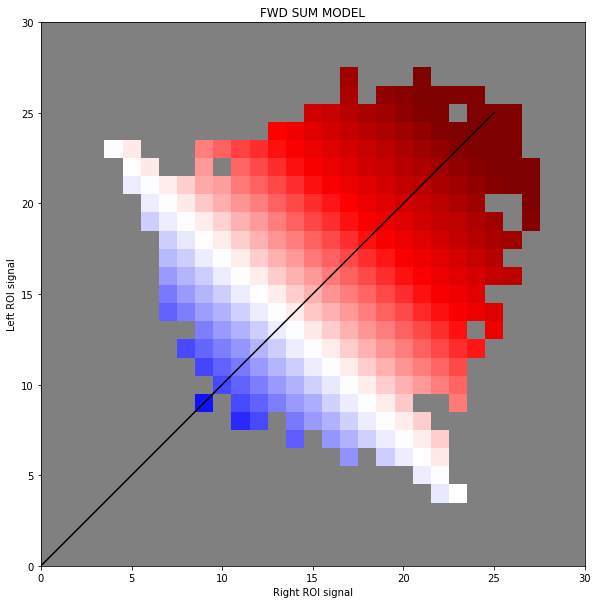

In [194]:
plt.figure(figsize=(10,10))

x_data = beh_fwd + noise1# + noise2
y_data = beh_fwd - noise1# + noise3

behavior = beh_fwd

start=-4
stop=8
num_bins=40
min_num_samples=10

# Define bins
bins = np.linspace(start,stop,num_bins)

# Assign neural values to bin numbers
idx_x, idx_y = np.digitize(x_data,bins), np.digitize(y_data,bins)

binned_signal = []
sample_count = []
for i in range(num_bins):
    mask_x = (idx_x == i)
    for j in range(num_bins):
        mask_y = (idx_y == j)
        mask = mask_x & mask_y

        binned_signal.append(np.mean(behavior[mask]))
        sample_count.append(np.count_nonzero(~np.isnan(behavior[mask])))

binned_signal = np.reshape(binned_signal,(num_bins, num_bins))
sample_count = np.reshape(sample_count,(num_bins, num_bins))

# Hide bins containing too few data points
binned_signal[np.where(sample_count<=min_num_samples)] = np.nan

cmap = plt.cm.get_cmap("seismic")
cmap.set_bad(color='grey')
plt.imshow(binned_signal,vmin=-3,vmax=3,cmap=cmap,origin='lower')
plt.ylabel('Left ROI signal')
plt.xlabel('Right ROI signal')
plt.plot([0,25],[0,25],color='k')
#plt.colorbar()
plt.ylim(0,30)
plt.xlim(0,30)
plt.title('FWD SUM MODEL')
#plt.suptitle(F"Clusters {cluster_}, {cluster_+250}",y=.72)

# Turn models

In [50]:
### OK, what about turning?
file = os.path.join(cluster_dir,"20221122_behavior_turn.npy")
beh_turn = np.load(file)
print(beh_turn.shape)

(30456,)


In [ ]:
### two models:
#1) ROI encodes a single turn direction
#2) ROI difference encodes both turn directions

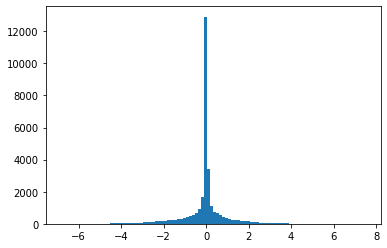

In [51]:
plt.hist(beh_turn,bins=100);

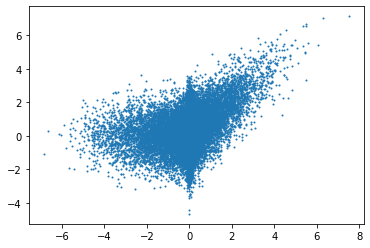

In [143]:
plt.scatter(beh_turn,noise1 + np.clip(beh_turn,0,None),s=1)

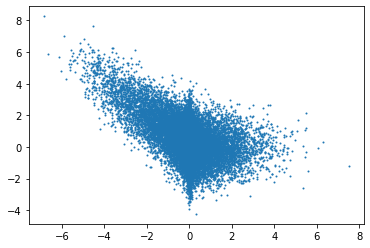

In [144]:
plt.scatter(beh_turn,noise2 - np.clip(beh_turn,None,0),s=1)

Text(0.5, 1.0, 'TURN INDEPENDENCE MODEL')

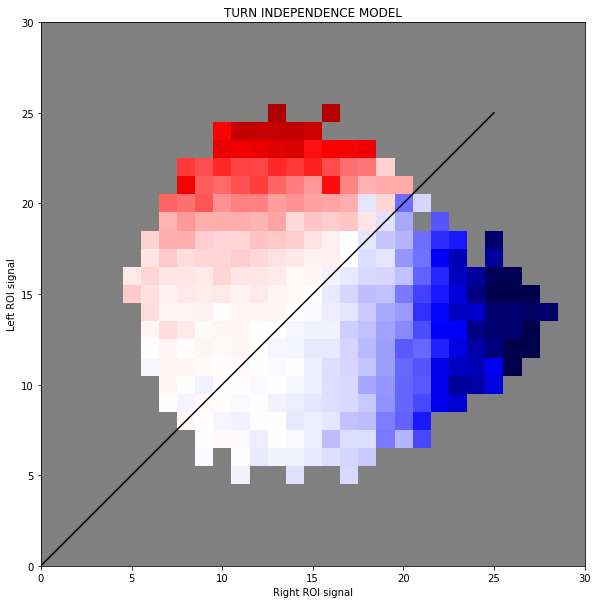

In [140]:
plt.figure(figsize=(10,10))

x_data = noise1 + np.clip(beh_turn,0,None)
y_data = noise2 - np.clip(beh_turn,None,0)

behavior = beh_turn

start=-4
stop=8
num_bins=40
min_num_samples=10

# Define bins
bins = np.linspace(start,stop,num_bins)

# Assign neural values to bin numbers
idx_x, idx_y = np.digitize(x_data,bins), np.digitize(y_data,bins)

binned_signal = []
sample_count = []
for i in range(num_bins):
    mask_x = (idx_x == i)
    for j in range(num_bins):
        mask_y = (idx_y == j)
        mask = mask_x & mask_y

        binned_signal.append(np.mean(behavior[mask]))
        sample_count.append(np.count_nonzero(~np.isnan(behavior[mask])))

binned_signal = np.reshape(binned_signal,(num_bins, num_bins))
sample_count = np.reshape(sample_count,(num_bins, num_bins))

# Hide bins containing too few data points
binned_signal[np.where(sample_count<=min_num_samples)] = np.nan

cmap = plt.cm.get_cmap("seismic")
cmap.set_bad(color='grey')
plt.imshow(binned_signal,vmin=-3,vmax=3,cmap=cmap,origin='lower')
plt.ylabel('Left ROI signal')
plt.xlabel('Right ROI signal')
plt.plot([0,25],[0,25],color='k')
#plt.colorbar()
plt.ylim(0,30)
plt.xlim(0,30)
plt.title("TURN INDEPENDENCE MODEL")
#plt.suptitle(F"Clusters {cluster_}, {cluster_+250}",y=.72)

In [ ]:
### try to model cluster 21
# this cluster doesn't have rectification, however its LvsR hist looks like the independent version

x_data = noise1 + np.clip(beh_turn,0,None)
y_data = noise2 - np.clip(beh_turn,None,0)


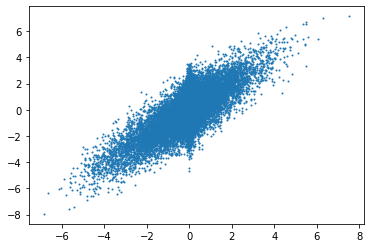

In [198]:
plt.scatter(beh_turn, beh_turn+noise1,s=1)

In [ ]:
# lets consider a few points
# (2,2) -> 0
# (1,2) -> -1
# (2,1) -> 1
# (10,9) -> 1

###
# so lets say roi1 = noise1
# then if roi2 = 

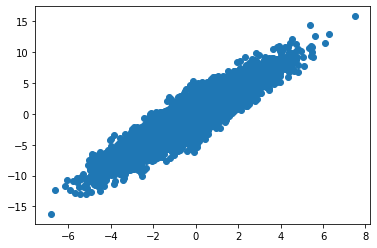

In [146]:
### TURN DIFFERENCE MODEL ###

x_data = noise1 + beh_turn
y_data = noise2 - beh_turn
plt.scatter(beh_turn,x_data-y_data)

Text(0.5, 1.0, 'TURN DIFFERENCE MODEL')

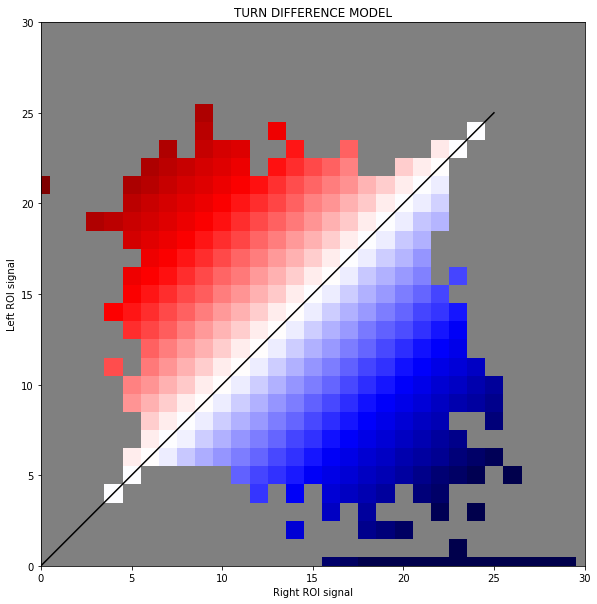

In [199]:
plt.figure(figsize=(10,10))

x_data = noise1 + beh_turn
y_data = noise1 - beh_turn

behavior = beh_turn

start=-4
stop=8
num_bins=40
min_num_samples=10

# Define bins
bins = np.linspace(start,stop,num_bins)

# Assign neural values to bin numbers
idx_x, idx_y = np.digitize(x_data,bins), np.digitize(y_data,bins)

binned_signal = []
sample_count = []
for i in range(num_bins):
    mask_x = (idx_x == i)
    for j in range(num_bins):
        mask_y = (idx_y == j)
        mask = mask_x & mask_y

        binned_signal.append(np.mean(behavior[mask]))
        sample_count.append(np.count_nonzero(~np.isnan(behavior[mask])))

binned_signal = np.reshape(binned_signal,(num_bins, num_bins))
sample_count = np.reshape(sample_count,(num_bins, num_bins))

# Hide bins containing too few data points
binned_signal[np.where(sample_count<=min_num_samples)] = np.nan

cmap = plt.cm.get_cmap("seismic")
cmap.set_bad(color='grey')
plt.imshow(binned_signal,vmin=-3,vmax=3,cmap=cmap,origin='lower')
plt.ylabel('Left ROI signal')
plt.xlabel('Right ROI signal')
plt.plot([0,25],[0,25],color='k')
#plt.colorbar()
plt.ylim(0,30)
plt.xlim(0,30)
plt.title("TURN DIFFERENCE MODEL")
#plt.suptitle(F"Clusters {cluster_}, {cluster_+250}",y=.72)